In [1]:
# install rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c rdkit rdkit python=3.7
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import pprint     
pprint.pprint(sys.path)
!python -c "import site; print (site.getsitepackages())"

installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /usr/local
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - python=3.7
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    bottleneck-1.3.4           |   py37hce1f21e_0         126 KB
    brotlipy-0.7.0             |py37h27cfd23_1003         320 KB
    bzip2-1.0.8                |       h7b6447c_0          78 KB
    ca-certificates-2022.07.19 |       h06a4308_0         124 KB
    cairo-1.16.0         

In [2]:
pip install spektral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 17.7 MB/s eta 0:00:00
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4832 sha256=12cf47b5584f260ac525e2e15314eb0bd111faeb4f2f7352194be12f985c9d88
  Stored in directory: /root/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
Successfully built termcolor


In [3]:
# import useful packages and functions
from spektral_package import *

In [4]:
import networkx as nx
import numpy as np
from scipy import sparse as sp

try:
    from rdkit import Chem as rdc
    from rdkit.Chem import Draw
    from rdkit import rdBase as rdb

    rdb.DisableLog('rdApp.error')  # RDKit logging is disabled by default
    Draw.DrawingOptions.dblBondOffset = .1
    BOND_MAP = {0: rdc.rdchem.BondType.ZERO,
                1: rdc.rdchem.BondType.SINGLE,
                2: rdc.rdchem.BondType.DOUBLE,
                3: rdc.rdchem.BondType.TRIPLE,
                4: rdc.rdchem.BondType.AROMATIC}
except ImportError:
    rdc = None
    rdb = None

NUM_TO_SYMBOL = {1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N',
                 8: 'O', 9: 'F', 10: 'Ne', 11: 'Na', 12: 'Mg', 13: 'Al',
                 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar', 19: 'K',
                 20: 'Ca', 21: 'Sc', 22: 'Ti', 23: 'V', 24: 'Cr', 25: 'Mn',
                 26: 'Fe', 27: 'Co', 28: 'Ni', 29: 'Cu', 30: 'Zn', 31: 'Ga',
                 32: 'Ge', 33: 'As', 34: 'Se', 35: 'Br', 36: 'Kr', 37: 'Rb',
                 38: 'Sr', 39: 'Y', 40: 'Zr', 41: 'Nb', 42: 'Mo', 43: 'Tc',
                 44: 'Ru', 45: 'Rh', 46: 'Pd', 47: 'Ag', 48: 'Cd', 49: 'In',
                 50: 'Sn', 51: 'Sb', 52: 'Te', 53: 'I', 54: 'Xe', 55: 'Cs',
                 56: 'Ba', 57: 'La', 58: 'Ce', 59: 'Pr', 60: 'Nd', 61: 'Pm',
                 62: 'Sm', 63: 'Eu', 64: 'Gd', 65: 'Tb', 66: 'Dy', 67: 'Ho',
                 68: 'Er', 69: 'Tm', 70: 'Yb', 71: 'Lu', 72: 'Hf', 73: 'Ta',
                 74: 'W', 75: 'Re', 76: 'Os', 77: 'Ir', 78: 'Pt', 79: 'Au',
                 80: 'Hg', 81: 'Tl', 82: 'Pb', 83: 'Bi', 84: 'Po', 85: 'At',
                 86: 'Rn', 87: 'Fr', 88: 'Ra', 89: 'Ac', 90: 'Th', 91: 'Pa',
                 92: 'U', 93: 'Np', 94: 'Pu', 95: 'Am', 96: 'Cm', 97: 'Bk',
                 98: 'Cf', 99: 'Es', 100: 'Fm', 101: 'Md', 102: 'No', 103: 'Lr',
                 104: 'Rf', 105: 'Db', 106: 'Sg', 107: 'Bh', 108: 'Hs',
                 109: 'Mt', 110: 'Ds', 111: 'Rg', 112: 'Cn', 113: 'Nh',
                 114: 'Fl', 115: 'Mc', 116: 'Lv', 117: 'Ts', 118: 'Og'}
SYMBOL_TO_NUM = {v: k for k, v in NUM_TO_SYMBOL.items()}


def numpy_to_rdkit(adj, nf, ef, sanitize=False):
    """
    Converts a molecule from numpy to RDKit format.
    :param adj: binary numpy array of shape (N, N)
    :param nf: numpy array of shape (N, F)
    :param ef: numpy array of shape (N, N, S)
    :param sanitize: whether to sanitize the molecule after conversion
    :return: an RDKit molecule
    """
    if rdc is None:
        raise ImportError('`numpy_to_rdkit` requires RDKit.')
    mol = rdc.RWMol()
    for nf_ in nf:
        atomic_num = int(nf_)
        if atomic_num > 0:
            mol.AddAtom(rdc.Atom(atomic_num))

    for i, j in zip(*np.triu_indices(adj.shape[-1])):
        if i != j and adj[i, j] == adj[j, i] == 1 and not mol.GetBondBetweenAtoms(int(i), int(j)):
            bond_type_1 = BOND_MAP[int(ef[i, j, 0])]
            bond_type_2 = BOND_MAP[int(ef[j, i, 0])]
            if bond_type_1 == bond_type_2:
                mol.AddBond(int(i), int(j), bond_type_1)

    mol = mol.GetMol()
    if sanitize:
        rdc.SanitizeMol(mol)
    return mol


def numpy_to_smiles(adj, nf, ef):
    """
    Converts a molecule from numpy to SMILES format.
    :param adj: binary numpy array of shape (N, N)
    :param nf: numpy array of shape (N, F)
    :param ef: numpy array of shape (N, N, S)
    :return: the SMILES string of the molecule
    """
    if rdc is None:
        raise ImportError('`numpy_to_smiles` requires RDkit.')
    mol = numpy_to_rdkit(adj, nf, ef)
    return rdkit_to_smiles(mol)


def rdkit_to_smiles(mol):
    """
    Returns the SMILES string representing an RDKit molecule.
    :param mol: an RDKit molecule
    :return: the SMILES string of the molecule
    """
    if rdc is None:
        raise ImportError('`rdkit_to_smiles` requires RDkit.')
    return rdc.MolToSmiles(mol)


def sdf_to_nx(sdf, keep_hydrogen=False):
    """
    Converts molecules in SDF format to networkx Graphs.
    :param sdf: a list of molecules (or individual molecule) in SDF format.
    :param keep_hydrogen: whether to include hydrogen in the representation.
    :return: list of nx.Graphs.
    """
    if not isinstance(sdf, list):
        sdf = [sdf]

    output = []
    for sdf_ in sdf:
        g = nx.Graph()

        for atom in sdf_['atoms']:
            if atom['atomic_num'] > 1 or keep_hydrogen:
                g.add_node(atom['index'], **atom)
        for bond in sdf_['bonds']:
            start_atom_num = sdf_['atoms'][bond['start_atom']]['atomic_num']
            end_atom_num = sdf_['atoms'][bond['end_atom']]['atomic_num']
            if (start_atom_num > 1 and end_atom_num > 1) or keep_hydrogen:
                g.add_edge(bond['start_atom'], bond['end_atom'], **bond)
        output.append(g)

    if len(output) == 1:
        return output[0]
    else:
        return output


def nx_to_sdf(graphs):
    """
    Converts a list of nx.Graphs to the internal SDF format.
    :param graphs: list of nx.Graphs.
    :return: list of molecules in the internal SDF format.
    """
    if isinstance(graphs, nx.Graph):
        graphs = [graphs]
    output = []
    for g in graphs:
        sdf = {'atoms': [v for k, v in g.nodes.items()],
               'bonds': [v for k, v in g.edges.items()],
               'comment': '',
               'data': [''],
               'details': '',
               'n_atoms': -1,
               'n_bonds': -1,
               'name': '',
               'properties': []}
        output.append(sdf)
    return output


def validate_rdkit_mol(mol):
    """
    Sanitizes an RDKit molecules and returns True if the molecule is chemically
    valid.
    :param mol: an RDKit molecule
    :return: True if the molecule is chemically valid, False otherwise
    """
    if rdc is None:
        raise ImportError('`validate_rdkit_mol` requires RDkit.')
    if len(rdc.GetMolFrags(mol)) > 1:
        return False
    try:
        rdc.SanitizeMol(mol)
        return True
    except ValueError:
        return False


def validate_rdkit(mol):
    """
    Validates RDKit molecules (single or in a list).
    :param mol: an RDKit molecule or list/np.array thereof
    :return: boolean array, True if the molecules are chemically valid, False
    otherwise
    """
    if rdc is None:
        raise ImportError('`validate_rdkit` requires RDkit.')
    if isinstance(mol, list) or isinstance(mol, np.ndarray):
        return np.array([validate_rdkit_mol(m) for m in mol])
    else:
        return validate_rdkit_mol(mol)

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
import pandas as pd
df = pd.read_csv('top_50_MOAs.txt', sep = '\t')
df

,SMILES,MOA
0,Oc1ccc(CCNCC2CCc3ccccc3C2=O)cc1,adrenergic receptor antagonist
1,OC(CNCCNC(=O)Nc1ccccc1)COc1ccccc1C#N,adrenergic receptor antagonist
2,O=C1Nc2ccccc2C2=NC(CN3CCN(CC3)c3ccccc3)CN12,adrenergic receptor antagonist
3,O=C(NC1CCN(CCc2c[nH]c3ccccc23)CC1)c1ccccc1,adrenergic receptor antagonist
4,O[C@H](CNC[C@@H](O)[C@@H]1CCc2cc(F)ccc2O1)[C@H...,adrenergic receptor antagonist
...,...,...
1958,Cn1c2ncn(CC(O)=O)c2c(=O)n(C)c1=O,adenosine receptor agonist
1959,CCNC(=O)[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(...,adenosine receptor agonist
1960,CCNC(=O)[C@H]1O[C@H]([C@@H](O)[C@@H]1O)n1cnc2c...,adenosine receptor agonist
1961,Cc1sc(N)c(C(=O)c2cccc(c2)C(F)(F)F)c1C,adenosine receptor agonist


In [ ]:
# check the duplicates 
for i in df.SMILES.tolist():
  if df.SMILES.tolist().count(i) != 1:
    print(i)

In [7]:
MOA_class_dictionary = {'ATPase inhibitor': 45,
 'Aurora kinase inhibitor': 7,
 'CC chemokine receptor antagonist': 13,
 'CDK inhibitor': 37,
 'DNA synthesis inhibitor': 29,
 'EGFR inhibitor': 41,
 'HCV inhibitor': 25,
 'HDAC inhibitor': 26,
 'HSP inhibitor': 23,
 'JAK inhibitor': 32,
 'MEK inhibitor': 5,
 'PARP inhibitor': 16,
 'PI3K inhibitor': 49,
 'PPAR receptor agonist': 9,
 'acetylcholine receptor agonist': 36,
 'acetylcholine receptor antagonist': 1,
 'acetylcholinesterase inhibitor': 46,
 'adenosine receptor agonist': 8,
 'adenosine receptor antagonist': 44,
 'adrenergic receptor agonist': 22,
 'adrenergic receptor antagonist': 10,
 'angiotensin converting enzyme inhibitor': 6,
 'antioxidant': 47,
 'bacterial 30S ribosomal subunit inhibitor': 14,
 'bacterial DNA gyrase inhibitor': 18,
 'bacterial cell wall synthesis inhibitor': 43,
 'benzodiazepine receptor agonist': 33,
 'bromodomain inhibitor': 2,
 'calcium channel blocker': 42,
 'cyclooxygenase inhibitor': 12,
 'cytochrome P450 inhibitor': 30,
 'dopamine receptor agonist': 48,
 'dopamine receptor antagonist': 27,
 'estrogen receptor agonist': 35,
 'glucocorticoid receptor agonist': 4,
 'glutamate receptor agonist': 19,
 'glutamate receptor antagonist': 20,
 'histamine receptor antagonist': 24,
 'histone lysine methyltransferase inhibitor': 11,
 'local anesthetic': 34,
 'monoamine oxidase inhibitor': 17,
 'opioid receptor agonist': 31,
 'phosphodiesterase inhibitor': 40,
 'potassium channel blocker': 15,
 'protein synthesis inhibitor': 28,
 'serotonin receptor agonist': 38,
 'serotonin receptor antagonist': 3,
 'sodium channel blocker': 39,
 'topoisomerase inhibitor': 21,
 'tubulin polymerization inhibitor': 0}

In [9]:
sorted_classes = list(MOA_class_dictionary.values())
sorted_classes.sort() 
assert sorted_classes == [i for i in range(50)]

In [10]:
# add classes column 
df['classes'] = None
for i in range(df.shape[0]):
  df.iloc[i,2] = MOA_class_dictionary[df.iloc[i,1]]
df

,SMILES,MOA,classes
0,Oc1ccc(CCNCC2CCc3ccccc3C2=O)cc1,adrenergic receptor antagonist,10
1,OC(CNCCNC(=O)Nc1ccccc1)COc1ccccc1C#N,adrenergic receptor antagonist,10
2,O=C1Nc2ccccc2C2=NC(CN3CCN(CC3)c3ccccc3)CN12,adrenergic receptor antagonist,10
3,O=C(NC1CCN(CCc2c[nH]c3ccccc23)CC1)c1ccccc1,adrenergic receptor antagonist,10
4,O[C@H](CNC[C@@H](O)[C@@H]1CCc2cc(F)ccc2O1)[C@H...,adrenergic receptor antagonist,10
...,...,...,...
1958,Cn1c2ncn(CC(O)=O)c2c(=O)n(C)c1=O,adenosine receptor agonist,8
1959,CCNC(=O)[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(...,adenosine receptor agonist,8
1960,CCNC(=O)[C@H]1O[C@H]([C@@H](O)[C@@H]1O)n1cnc2c...,adenosine receptor agonist,8
1961,Cc1sc(N)c(C(=O)c2cccc(c2)C(F)(F)F)c1C,adenosine receptor agonist,8


In [11]:
# A function that changes smiles string to fingerprints 
import rdkit
import numpy as np
from rdkit import *
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
def smiles_to_array_to_string(smiles):
  molecules = Chem.MolFromSmiles(smiles) 
  fingerprints = AllChem.GetMorganFingerprintAsBitVect(molecules, 2)
  x_array = []
  arrays  = np.zeros(0,)
  DataStructs.ConvertToNumpyArray(fingerprints, arrays)
  x_array.append(arrays)
  x_array = np.asarray(x_array)
  x_array = list((np.squeeze(x_array)).astype(int))
  string = ''
  for i in x_array:
    string += str(i) 
  return string

In [12]:
# Check the existence of Isomers
assert len(set([smiles_to_array_to_string(i) for i in df.SMILES.tolist()])) == df.shape[0]

In [13]:
df

,SMILES,MOA,classes
0,Oc1ccc(CCNCC2CCc3ccccc3C2=O)cc1,adrenergic receptor antagonist,10
1,OC(CNCCNC(=O)Nc1ccccc1)COc1ccccc1C#N,adrenergic receptor antagonist,10
2,O=C1Nc2ccccc2C2=NC(CN3CCN(CC3)c3ccccc3)CN12,adrenergic receptor antagonist,10
3,O=C(NC1CCN(CCc2c[nH]c3ccccc23)CC1)c1ccccc1,adrenergic receptor antagonist,10
4,O[C@H](CNC[C@@H](O)[C@@H]1CCc2cc(F)ccc2O1)[C@H...,adrenergic receptor antagonist,10
...,...,...,...
1958,Cn1c2ncn(CC(O)=O)c2c(=O)n(C)c1=O,adenosine receptor agonist,8
1959,CCNC(=O)[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(...,adenosine receptor agonist,8
1960,CCNC(=O)[C@H]1O[C@H]([C@@H](O)[C@@H]1O)n1cnc2c...,adenosine receptor agonist,8
1961,Cc1sc(N)c(C(=O)c2cccc(c2)C(F)(F)F)c1C,adenosine receptor agonist,8


In [14]:
structures = df.SMILES.tolist()

In [15]:
molecule_blocks = []
for structure in structures:
  molecule = Chem.MolFromSmiles(structure)
  molecule_block = Chem.MolToMolBlock(molecule)
  molecule_blocks.append(molecule_block)

In [16]:
molecule_textfile = open("molecule_textfile.txt", "w")
for molecule_block in molecule_blocks:
  molecule_textfile.write(molecule_block + "\n" + '$$$$' + "\n")
molecule_textfile.close()

In [17]:
from spektral.utils.io import load_sdf
molecule_sdf_loaded = load_sdf("molecule_textfile.txt", amount = None)

Reading SDF


In [18]:
import networkx as nx
molecule_sdf_nx = sdf_to_nx(molecule_sdf_loaded, keep_hydrogen = True)

In [19]:
molecule_sdf_adj, molecule_sdf_node, _ = nx_to_numpy(molecule_sdf_nx, nf_keys=['atomic_num'],ef_keys=['type'] )

/content/spektral_package.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(nx.attr_matrix(g)[0]) for g in graphs])
/content/spektral_package.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(output)
/content/spektral_package.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  retu

In [20]:
uniq_node = np.unique([v for x in molecule_sdf_node for v in np.unique(x)])
node = [label_to_one_hot(x, uniq_node) for x in molecule_sdf_node]

In [21]:
y = [int(i) for i in df['classes'].tolist()]

In [22]:
n_nodes = node[0].shape[-2]           
n_features = node[0].shape[-1]         
n_classes = len(set(y))    

In [23]:
X = list(df.index)

In [24]:
# Split out the test set    
from sklearn.model_selection import train_test_split
x_train_valid, x_test, y_train_valid, y_test= train_test_split(X, df.classes.tolist(), test_size =10/100,
      stratify = df.classes.tolist(), shuffle=True, random_state = 1000)

In [25]:
# kfold 
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 9)
skf.get_n_splits(np.array(list(x_train_valid)), np.array(list(y_train_valid)))
train_index_list = []
valid_index_list = []
for train_index, valid_index in skf.split(np.array(list(x_train_valid)), np.array(list(y_train_valid))):
  train_index_list.append(train_index)
  valid_index_list.append(valid_index)

In [26]:
number_of_kfold = 0 # Change this from 0-8 to get 9 shuffles 

In [27]:
x_train = list(np.array(list(x_train_valid))[train_index_list[ number_of_kfold ]])
x_valid = list(np.array(list(x_train_valid))[valid_index_list[ number_of_kfold ]])
y_train = list(np.array(list(y_train_valid))[train_index_list[ number_of_kfold ]])
y_valid = list(np.array(list(y_train_valid))[valid_index_list[ number_of_kfold ]])
x_test = list(x_test)
y_test = list(y_test)

In [28]:
# Get adjacency matrix       
A_train = molecule_sdf_adj[x_train]
A_valid = molecule_sdf_adj[x_valid]
A_test = molecule_sdf_adj[x_test]

In [29]:
# get node matrix   
X_train = []
for i in  x_train:
  X_train.append(node[i])

In [30]:
X_valid = []
for i in  x_valid:
  X_valid.append(node[i]) 

In [31]:
X_test = []
for i in x_test:
  X_test.append(node[i])  

In [32]:
# Check the overlap 
for i in x_train:
  if i in x_valid:
    print(i)

In [33]:
for i in x_test:
  if i in x_train:
    print(i)

In [34]:
for i in x_test:
  if i in x_valid:
    print(i)

In [35]:
X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)
X_test = np.asarray(X_test)

In [36]:
from tensorflow.keras.regularizers import l2
from spektral.layers import GCSConv, GlobalAttentionPool
from keras.layers import Dropout, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

units = 128
drop = 0.5
batch_size = 8
l2_reg = 5e-4

X_in = Input((n_nodes, n_features))
A_in = Input((n_nodes, n_nodes))
layer = GCSConv(units, activation='relu', kernel_regularizer=l2(l2_reg))([X_in, A_in])
layer = Dropout(drop)(layer)
layer = GCSConv(units, activation='relu', kernel_regularizer=l2(l2_reg))([layer, A_in])
layer = Dropout(drop)(layer)
layer = GCSConv(units, activation='relu', kernel_regularizer=l2(l2_reg))([layer, A_in])
layer = Dropout(drop)(layer) 
layer = GlobalAttentionPool(units*2)(layer)
output = Dense(n_classes, activation='softmax')(layer)

model0 = Model(inputs = [X_in, A_in], outputs = output)
optimizer = Adam(lr = 1e-3)
model0.compile(optimizer = optimizer,loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
# Create class weights
from sklearn.utils import class_weight
y_unique = np.unique(np.array(y_train))
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = y_unique,
                y = np.array(y_train)) 
class_weights_dict45 = dict(enumerate(class_weights))
class_weights_dict45

{0: 1.651578947368421,
 1: 0.47545454545454546,
 2: 1.8458823529411765,
 3: 0.5705454545454546,
 4: 0.8716666666666667,
 5: 1.8458823529411765,
 6: 1.651578947368421,
 7: 1.8458823529411765,
 8: 1.8458823529411765,
 9: 1.7433333333333334,
 10: 0.41289473684210526,
 11: 1.4942857142857142,
 12: 0.4023076923076923,
 13: 1.3643478260869566,
 14: 1.651578947368421,
 15: 1.651578947368421,
 16: 1.7433333333333334,
 17: 1.569,
 18: 1.3075,
 19: 1.4942857142857142,
 20: 0.5410344827586206,
 21: 1.046,
 22: 0.4683582089552239,
 23: 1.651578947368421,
 24: 0.5603571428571429,
 25: 1.96125,
 26: 1.012258064516129,
 27: 0.6276,
 28: 1.1207142857142858,
 29: 1.569,
 30: 1.651578947368421,
 31: 1.651578947368421,
 32: 1.8458823529411765,
 33: 1.1207142857142858,
 34: 1.651578947368421,
 35: 1.651578947368421,
 36: 0.9229411764705883,
 37: 1.206923076923077,
 38: 0.65375,
 39: 1.012258064516129,
 40: 0.6404081632653061,
 41: 0.980625,
 42: 0.8716666666666667,
 43: 0.41289473684210526,
 44: 1.4263636

In [38]:
from keras.callbacks import ModelCheckpoint
filepath_gcn = '/content/'+'GCN_top_'+str(n_classes)+'_MOA_weights.hdf5'
checkpoint_gcn = ModelCheckpoint(filepath_gcn, save_weights_only = True, monitor = 'val_accuracy',
         verbose = 0, save_best_only = True, mode = 'max')

In [39]:
import gc
gc.collect()

1611

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 80, verbose = 1, mode = 'min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
          factor = 0.98, patience = 5, verbose = 0, min_delta = 1e-54, mode = 'min')
history = model0.fit([[X_train, A_train]], np.array(y_train), batch_size = batch_size,
          validation_data = [[X_valid, A_valid], np.array(y_valid)], 
          shuffle = True, class_weight = class_weights_dict45, epochs = 300, 
          verbose = 2, callbacks = [earlyStopping, checkpoint_gcn, reduce_lr_loss,])

197/197 - 1s - loss: 1.7025 - accuracy: 0.5315 - val_loss: 3.2515 - val_accuracy: 0.4365 - lr: 7.3857e-04 - 963ms/epoch - 5ms/step
Epoch 126/300
197/197 - 1s - loss: 1.7010 - accuracy: 0.5296 - val_loss: 3.3504 - val_accuracy: 0.4213 - lr: 7.3857e-04 - 968ms/epoch - 5ms/step
Epoch 127/300
197/197 - 1s - loss: 1.6693 - accuracy: 0.5398 - val_loss: 3.3762 - val_accuracy: 0.4264 - lr: 7.3857e-04 - 990ms/epoch - 5ms/step
Epoch 128/300
197/197 - 1s - loss: 1.7311 - accuracy: 0.5220 - val_loss: 3.3629 - val_accuracy: 0.4467 - lr: 7.3857e-04 - 993ms/epoch - 5ms/step
Epoch 129/300
197/197 - 1s - loss: 1.7142 - accuracy: 0.5290 - val_loss: 3.2195 - val_accuracy: 0.4315 - lr: 7.2380e-04 - 968ms/epoch - 5ms/step
Epoch 130/300
197/197 - 1s - loss: 1.6806 - accuracy: 0.5214 - val_loss: 3.1392 - val_accuracy: 0.4365 - lr: 7.2380e-04 - 979ms/epoch - 5ms/step
Epoch 131/300
197/197 - 1s - loss: 1.6969 - accuracy: 0.5214 - val_loss: 3.3438 - val_accuracy: 0.4264 - lr: 7.2380e-04 - 1s/epoch - 5ms/step
Ep

In [41]:
# Load the weights 
model0.load_weights(filepath_gcn)

In [43]:
# Evaluate the model 
from sklearn.metrics import classification_report
assert list(y_test)[0:5] == [17, 8, 7, 22, 4]
print(classification_report(y_valid, np.array(model0.predict([X_valid, A_valid]).argmax(-1)),))
print(classification_report(y_test, np.array(model0.predict([X_test, A_test]).argmax(-1)),))

              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.75      0.33      0.46         9
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         7
           4       1.00      1.00      1.00         5
           5       0.50      0.50      0.50         2
           6       0.50      1.00      0.67         2
           7       0.33      0.50      0.40         2
           8       0.40      1.00      0.57         2
           9       0.50      0.67      0.57         3
          10       0.70      0.78      0.74         9
          11       1.00      1.00      1.00         2
          12       0.80      0.40      0.53        10
          13       0.33      0.33      0.33         3
          14       0.50      0.50      0.50         2
          15       0.14      0.33      0.20         3
          16       0.17      0.50      0.25         2
          17       0.50    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [44]:
number_of_kfold,  y_train[0:5],   y_valid[0:5],  (y_test[0:5])

(0, [6, 17, 43, 3, 21], [17, 43, 38, 43, 19], [17, 8, 7, 22, 4])

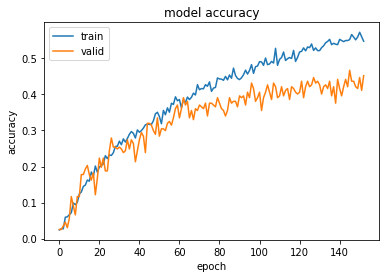

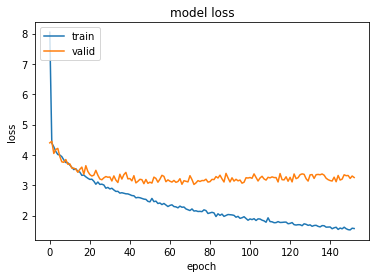

In [45]:
# Training curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

In [46]:
# References 
# https://codesuche.com/view-source/python/danielegrattarola/spektral/ 
# https://github.com/Discngine/dng_dl_speknn 
# https://github.com/danielegrattarola/spektral